# Baseline 

To evaluate the performance of our predictor, we compare it to ERGO, ImRex, and TITAN.

In [1]:
import warnings
import pandas as pd
import numpy as np
from itertools import product
from sklearn import metrics
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [2]:
import sys
sys.path.append('../activation-prediction/')

In [3]:
from preprocessing import add_activation_thresholds, full_aa_features, get_aa_features 
from preprocessing import get_complete_dataset, get_tumor_dataset

# 1. Raw Data

In [4]:
data = get_complete_dataset()
data = add_activation_thresholds(data)
print(len(data))
data = data[data['normalization']=='AS']
data = data[data['threshold']=='46.9']
data = data[data['epitope']!='SIINFEKL']
#data = data[data['is_educated']==True]
print(len(data))

30753
4104


In [5]:
data_tumor = get_tumor_dataset()
data_tumor = add_activation_thresholds(data_tumor, epitope='VPSVWRSSL')
print(len(data_tumor))
data_tumor = data_tumor[data_tumor['normalization']=='pc']
data_tumor = data_tumor[data_tumor['threshold']=='66.09']
data_tumor = data_tumor[data_tumor['epitope']!='VPSVWRSSL']
print(len(data_tumor))

1608
798


# 2. Data Preparation

### Ergo

Creates a csv file with columns [CDR3, epitope]. All combinations between the TCRs of the educated repertoire and the mutations are used.

In [6]:
def format_to_ergo(df, cols=None, name='ergo_baseline_all_pairs'):
    if cols is None:
        cols = []
    data_ergo = df[['cdr3b', 'cdr3a', 'epitope', 'tcr'] + cols]
    data_ergo = data_ergo.rename(columns={'cdr3b': 'TRB', 'cdr3a': 'TRA', 'epitope': 'Peptide'})
    for col in ['TRAV', 'TRAJ', 'TRBV', 'TRBJ', 'T-Cell-Type', 'MHC']:
        data_ergo[col] = ''
    data_ergo.to_csv(f'data/{name}.csv')
    return data_ergo

data_ergo = format_to_ergo(data, cols=['is_educated']).head(5)

In [7]:
data_ergo_tumor = format_to_ergo(data_tumor, name='ergo_tumor_baseline_all_pairs').head(5)

### ImRex

https://github.com/pmoris/ImRex

In [8]:
def format_to_imrex(df, cols=None, name='imrex_baseline_all_pairs'):
    if cols is None:
        cols = []
    df_imrex = df[['cdr3b', 'cdr3a', 'epitope', 'tcr', ] + cols]
    df_imrex = df_imrex.rename(columns={'cdr3b': 'cdr3', 'epitope': 'antigen.epitope'})
    df_imrex.to_csv(f'data/{name}.csv', sep=';', index=False)
    return df_imrex
data_imrex = format_to_imrex(data, cols=['is_educated']).head(5)

In [9]:
data_imrex_tumor = format_to_imrex(data_tumor, name='imrex_tumor_baseline_all_pairs').head(5)

### Titan
https://github.com/PaccMann/TITAN
The data needs to be in the following format:
- tcrs (csv): sequence, id
- epitopes (csv): sequence, id
- test_tcrs (csv): id_tcr, id_epitope, label (label dummy value)

Both csv files without header + tab separated.

In [10]:
def format_to_titan(df, cols=None, name='titan_'):
    data_epitope = df[['epitope']]
    data_epitope['id'] = data_epitope.index.values
    data_epitope.to_csv(f'data/{name}_epitopes.csv', sep='\t', index=False, header=False)
    
    data_tcr = df[['cdr3b']]
    data_tcr['id'] = data_tcr.index.values
    data_tcr.to_csv(f'data/{name}_tcrs.csv', sep='\t', index=False, header=False)
    
    data_test = data_tcr[['id']]
    data_test['ligand_name'] = data_epitope['id'].values
    data_test['sequence_id'] = data_tcr['id'].values
    data_test['label'] = df.apply(lambda row: 1 if row['is_activated'] else 0, axis=1)
    data_test = data_test[['ligand_name', 'sequence_id', 'label']]
    data_test.to_csv(f'data/{name}_test_ids.csv')
    return data_epitope, data_tcr, data_test

_, _, _ = format_to_titan(data, cols=['is_educated'])

In [11]:
_, _, _ = format_to_titan(data_tumor, name='titan_tumor')

# 3. Prediction
Prediction with the individual models was performed in external conda environments to avoid dependency conflicts.

### Ergo
Prediction was performed as described in https://github.com/IdoSpringer/ERGO-II using the github version and downloaded models. You will need to adjust the ERGO-II code to save a dataframe. Also, smaller bugs need to be fixed following the GitHub issues.

```
python Predict.py mcpas ../data/ergo_baseline_all_pairs.csv ../results_pred/ergo_mcpas.csv
python Predict.py vdjdb ../data/ergo_baseline_all_pairs.csv ../results_pred/ergo_vdjdb.csv

python Predict.py mcpas ../data/ergo_tumor_baseline_all_pairs.csv ../results_pred/ergo_mcpas_tumor.csv
python Predict.py vdjdb ../data/ergo_tumor_baseline_all_pairs.csv ../results_pred/ergo_vdjdb_tumor.csv
```

### Imrex
```
python src/scripts/predict/predict.py --model ./models/pretrained/2020-07-24_19-18-39_trbmhcidown-shuffle-padded-b32-lre4-reg001/2020-07-24_19-18-39_trbmhcidown-shuffle-padded-b32-lre4-reg001.h5 --input ../data/imrex_baseline_all_pairs.csv --output ../results_pred/imrex.csv
python src/scripts/predict/predict.py --model ./models/pretrained/2020-07-24_19-18-39_trbmhcidown-shuffle-padded-b32-lre4-reg001/2020-07-24_19-18-39_trbmhcidown-shuffle-padded-b32-lre4-reg001.h5 --input ../data/imrex_tumor_baseline_all_pairs.csv --output ../results_pred/imrex_tumor.csv
```

### TITAN
- Install TITAN from github (see above) including the pretrained model referenced on github
- Use their pytoda module to convert the input_titan_epitopes.csv to smi
- Change the batch size in model_params.json to a true divider of the dataset size since otherwise the last batch is not handled correctly
- Run following comand with adapted paths depending on your installation

Data Preprocessing (Not part of the notebook as it needs the TITAN dependencies, Sorry, for inconvenience)
```
from pytoda import proteins
import pandas as pd

def amino_2_smiles(df_aas, path_out):
    df_aas['smiles'] = df_aas[0].apply(proteins.utils.aas_to_smiles)
    df_aas = df_aas[['smiles', 1]]
    df_aas.to_csv(path_out, header=None, sep='\t', index=False)

df_siin = pd.read_csv('../data/titan__epitopes.csv', sep='\t', header=None)
amino_2_smiles(df_siin, '../data/titan__epitopes.smi')

df_tumor = pd.read_csv('../data/titan_tumor_epitopes.csv', sep='\t', header=None)
amino_2_smiles(df_tumor, '../data/titan_tumor_epitopes.smi')
```

Running Predictors:

```
python scripts/flexible_model_eval.py ../data/titan__test_ids.csv ../data/titan__tcrs.csv ../data/titan__epitopes.smi trained_model bimodal_mca ../../../results_pred/titan

python scripts/flexible_model_eval.py ../data/titan_tumor_test_ids.csv ../data/titan_tumor_tcrs.csv ../data/titan_tumor_epitopes.smi trained_model bimodal_mca ../../../results_pred/titan_tumor
```

# 4. Output

In [12]:
def transform_imrex_output(name_in, tumor=False):
    df = pd.read_csv(name_in)
    df = df.rename(columns={'prediction_score': 'prediction'})
    
    ground_truth = data
    if tumor:
        ground_truth = data_tumor
    
    # Check whether order is right
    assert (df['cdr3'].values == ground_truth['cdr3b'].values).all()
    assert (df['tcr'].values == ground_truth['tcr'].values).all()
    assert (df['antigen.epitope'].values == ground_truth['epitope'].values).all()
    
    df['activation'] = ground_truth['activation'].values
    df['is_activated'] = ground_truth['is_activated'].values
    
    df = df[~df['antigen.epitope'].isin(['SIINFEKL', 'VPSVWRSSL'])].copy()
    return df

In [13]:
def transform_ergo_output(name_in, tumor=False):
    df = pd.read_csv(name_in)
    df = df.rename(columns={'Score': 'prediction'})
    
    ground_truth = data
    if tumor:
        ground_truth = data_tumor
    
    # Check whether order is right
    assert (df['TRB'].values == ground_truth['cdr3b'].values).all()
    assert (df['tcr'].values == ground_truth['tcr'].values).all()
    assert (df['Peptide'].values == ground_truth['epitope'].values).all()
    
    df['activation'] = ground_truth['activation'].values
    df['is_activated'] = ground_truth['is_activated'].values
    return df

In [14]:
def transform_titan_output(name_in, tumor=False):
    path_titan_res = f'results/output_titan_prediction.npy'
    scores = np.load(name_in)[0]
    df = data.copy()
    if tumor:
        df = data_tumor
    df['prediction'] = scores
    return df

In [15]:
def transform_ours_output(name_in, tumor=False):
    df = pd.read_csv(name_in, compression='gzip')
    if not tumor:
        df = df[df['normalization']=='AS']
        df = df[df['threshold']==46.9]
        df = df[df['tcr'].isin(data['tcr'].unique())]
    else:
        df = df[df['normalization']=='pc']
        df = df[df['threshold']==66.09]
        df = df[df['tcr'].isin(data_tumor['tcr'].unique())]
        df = df[df['reduced_features']]
    
    df = df.rename(columns={'pred': 'prediction'})
    
    ground_truth = data.copy()
    base_epitope = 'SIINFEKL'
    if tumor:
        ground_truth = data_tumor.copy()
        base_epitope = 'VPSVWRSSL'
    
    def create_epitope(row):
        pos = row['mut_pos']
        aa = row['mut_ami']
        epitope = base_epitope[:pos] + aa + base_epitope[pos+1:]
        return epitope
    
    df['epitope'] = df.apply(create_epitope, axis=1)
    
    # Check whether order is right    
    assert (df['tcr'].values == ground_truth['tcr'].values).all()
    assert (df['epitope'].values == ground_truth['epitope'].values).all()
    
    df['activation'] = ground_truth['activation'].values
    df['is_activated'] = ground_truth['is_activated'].values
    return df
transform_ours_output('results_pred/VPSVWRSSL_tcr_stratified_classification_performance.csv.gz', True)

,normalization,threshold,tcr,mut_pos,mut_ami,wild_activation,activation,is_activated,prediction,reduced_features,epitope
1596,pc,66.09,R21,0,R,76.687898,40.891720,False,0.382,True,RPSVWRSSL
1597,pc,66.09,R21,0,A,76.687898,1.522293,False,0.391,True,APSVWRSSL
1598,pc,66.09,R21,0,S,76.687898,4.955414,False,0.413,True,SPSVWRSSL
1599,pc,66.09,R21,0,K,76.687898,1.248408,False,0.253,True,KPSVWRSSL
1600,pc,66.09,R21,0,H,76.687898,1.127389,False,0.390,True,HPSVWRSSL
...,...,...,...,...,...,...,...,...,...,...,...
2389,pc,66.09,R28,7,W,66.092943,23.580034,False,0.824,True,VPSVWRSWL
2390,pc,66.09,R28,8,M,66.092943,67.125645,True,0.787,True,VPSVWRSSM
2391,pc,66.09,R28,8,F,66.092943,45.697074,False,0.820,True,VPSVWRSSF
2392,pc,66.09,R28,8,I,66.092943,69.707401,True,0.944,True,VPSVWRSSI


In [16]:
predictions_siinfekl = {
    'imRex': transform_imrex_output('results_pred/imrex.csv'),
    'ERGO-II_mcpas': transform_ergo_output('results_pred/ergo_mcpas.csv'),
    'ERGO-II_vdjdb': transform_ergo_output('results_pred/ergo_vdjdb.csv'),
    'TITAN': transform_titan_output('results_pred/titan.npy'),
    'Ours': transform_ours_output('results_pred/SIINFEKL_tcr_stratified_classification_performance.csv.gz')
}

predictions_tumor = {
    'imRex': transform_imrex_output('results_pred/imrex_tumor.csv', True),
    'ERGO-II_mcpas': transform_ergo_output('results_pred/ergo_mcpas_tumor.csv', True),
    'ERGO-II_vdjdb': transform_ergo_output('results_pred/ergo_vdjdb_tumor.csv', True),
    'TITAN': transform_titan_output('results_pred/titan_tumor.npy', True),
    'Ours': transform_ours_output('results_pred/VPSVWRSSL_tcr_stratified_classification_performance.csv.gz', True)
}

# 5. Evaluation

In [17]:
def evaluate_model(df_pred):
    tcrs = []
    aucs = []
    spearmans = []
    for tcr in df_pred['tcr'].unique():
        df_test = df_pred[df_pred['tcr'] == tcr]
        tcrs.append(tcr)

        auc_score = metrics.roc_auc_score(df_test['is_activated'], df_test['prediction'])
        aucs.append(auc_score)
        
        sp_score = df_test['activation'].corr(df_test['prediction'], method='spearman')
        spearmans.append(sp_score)
    df_out = pd.DataFrame(data={'TCR': tcrs, 'AUC': aucs, 'Spearman': spearmans})
    return df_out
    
performance_siinfekl = {name: evaluate_model(preds) for name, preds in predictions_siinfekl.items()}
performance_tumor = {name: evaluate_model(preds) for name, preds in predictions_tumor.items()}

In [18]:
educated_colors = sns.color_palette('Oranges', n_colors=len(data.query('is_educated')['tcr'].unique()) + 4)
educated_idx = 1

naive_colors = sns.color_palette('Blues', n_colors=len(data.query('~is_educated')['tcr'].unique()) + 4)
naive_idx = 1

ot1_colors = sns.color_palette('Greens', n_colors=2)
ot1_idx = 1

tumor_colors = sns.color_palette('Reds', n_colors=8)
tumor_idx = 1

tcr_2_color ={}
for tcr in data['tcr'].unique().tolist() + data_tumor['tcr'].unique().tolist():
    if tcr == 'OTI_PH':
        tcr_2_color[tcr] = ot1_colors[ot1_idx]
        ot1_idx += 1
    elif tcr.startswith('ED'):
        tcr_2_color[tcr] = educated_colors[educated_idx]
        educated_idx += 1
    elif tcr.startswith('R'):
        tcr_2_color[tcr] = tumor_colors[tumor_idx]
        tumor_idx += 1
    else:
        tcr_2_color[tcr] = naive_colors[naive_idx]
        naive_idx += 1

In [19]:
def summarize(perf, metric):
    df_summary = pd.DataFrame(index=list(perf.values())[0]['TCR'])
    for name, df in perf.items():
        df_summary[f'{name}'] = df[metric].values
    
    df_summary = df_summary[~df_summary.index.isin(['LR_OTI_1', 'LR_OTI_2'])]
    df_summary['color'] = df_summary.index.map(tcr_2_color)
    return df_summary
siinfekl_auc = summarize(performance_siinfekl, metric='AUC')
siinfekl_spearman = summarize(performance_siinfekl, metric='Spearman')

tumor_auc = summarize(performance_tumor, metric='AUC')
tumor_spearman = summarize(performance_tumor, metric='Spearman')

# 6. Summary

In [20]:
print('SIINFEKL Mean AUC:\n', siinfekl_auc.mean())
print('\nSIINFEKL Mean Spearman:\n', siinfekl_spearman.mean())

print('Tumor Mean AUC:\n', tumor_auc.mean())
print('\nTumor Mean Spearman:\n', tumor_spearman.mean())

SIINFEKL Mean AUC:
 imRex            0.508514
ERGO-II_mcpas    0.474635
ERGO-II_vdjdb    0.555266
TITAN            0.493062
Ours             0.799553
dtype: float64

SIINFEKL Mean Spearman:
 imRex            0.007747
ERGO-II_mcpas   -0.054683
ERGO-II_vdjdb    0.118910
TITAN           -0.050605
Ours             0.677253
dtype: float64
Tumor Mean AUC:
 imRex            0.528689
ERGO-II_mcpas    0.655928
ERGO-II_vdjdb    0.481992
TITAN            0.550933
Ours             0.772530
dtype: float64

Tumor Mean Spearman:
 imRex            0.002937
ERGO-II_mcpas    0.307817
ERGO-II_vdjdb   -0.108433
TITAN            0.148708
Ours             0.590292
dtype: float64


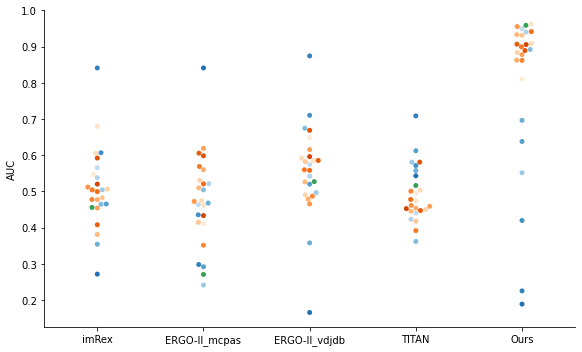

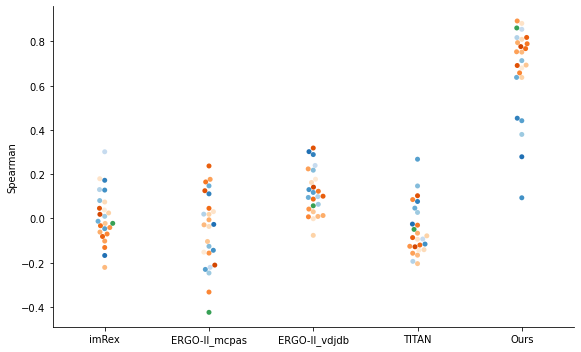

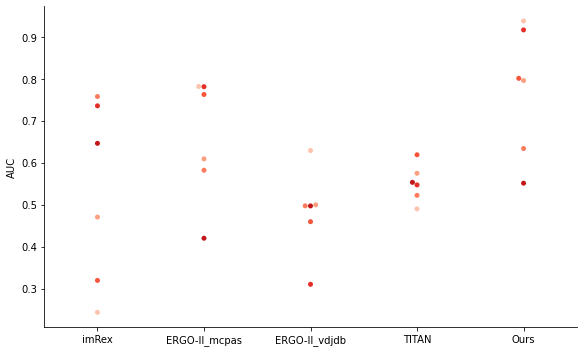

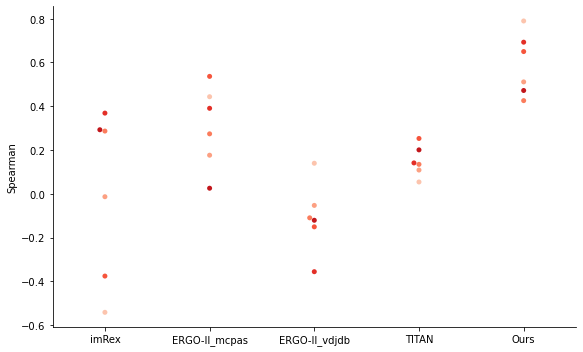

In [21]:
def catplot(df, metric):
    df_tmp = df.copy()
    df_tmp['TCR'] = df_tmp.index
    df_tmp = df_tmp.melt(['TCR', 'color'])
    plot_cat = sns.catplot(data=df_tmp, x='variable', y='value', hue='TCR',
                          palette=df_tmp['color'],
                          kind='swarm',
                          height=5, aspect=8/5)
    plot_cat.set(ylabel=metric)

    plot_cat._legend.remove()
    plot_cat.set(xlabel=None)
    plt.grid(False)
    sns.despine()
    plt.plot()

catplot(siinfekl_auc, 'AUC')
catplot(siinfekl_spearman, 'Spearman')
catplot(tumor_auc, 'AUC')
catplot(tumor_spearman, 'Spearman')